In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
from google.colab import files
import io
#Import using timevary.csv here
uploaded = files.upload()
filename = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='latin1')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nUnique individuals:", df['id'].nunique())
print("Months per person:", df.groupby('id')['month'].count().describe())

# Converting data types
df['SES_quintile'] = df['SES_quintile'].astype('category')
df['Race'] = df['Race'].astype('category')
df['month'] = df['month'].astype(int)

print("\nMissing values:")
print(df.isnull().sum())

Saving timevary_assignment.csv to timevary_assignment.csv
Dataset shape: (4800, 8)

First few rows:
   id  month  SES_quintile   Race  temp_mean  green_ndvi  unemploy_rate  \
0   1      1             4  Asian  21.295377   74.576544       5.848770   
1   1      2             4  Asian  23.191980   60.232330       7.715773   
2   1      3             4  Asian  24.061051   56.340480       5.504873   
3   1      4             4  Asian  22.728795   25.099608       7.625555   
4   1      5             4  Asian  17.974338   44.121674       4.837964   

   outcome  
0        0  
1        0  
2        0  
3        0  
4        0  

Data types:
id                 int64
month              int64
SES_quintile       int64
Race              object
temp_mean        float64
green_ndvi       float64
unemploy_rate    float64
outcome            int64
dtype: object

Unique individuals: 200
Months per person: count    200.0
mean      24.0
std        0.0
min       24.0
25%       24.0
50%       24.0
75%       

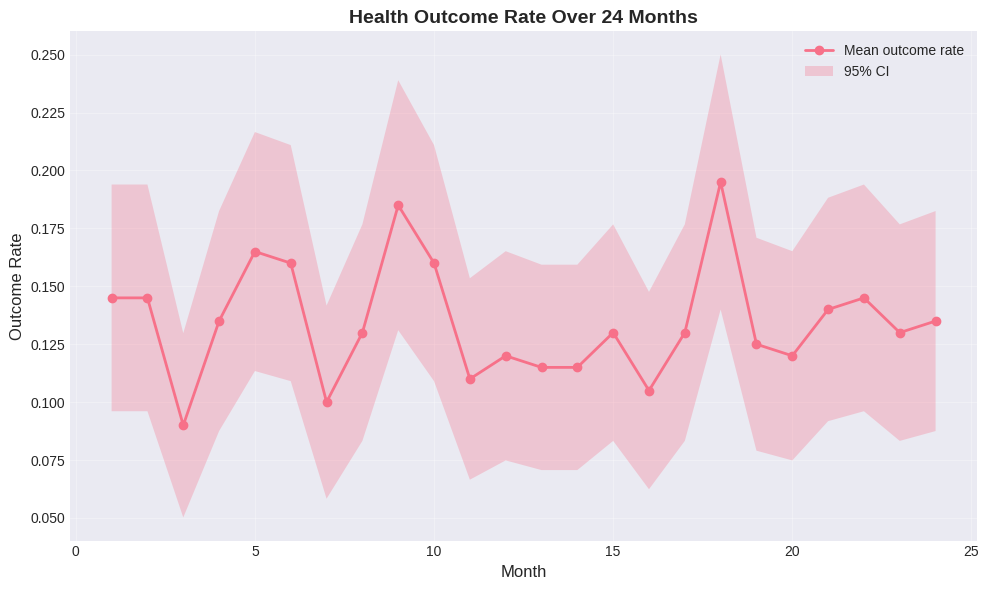

Outcome rate ranges from 0.090 to 0.195
Is there a trend? Let's check correlation with time:
Correlation: -0.024


In [3]:
# Calculate outcome rate by month
outcome_by_month = df.groupby('month')['outcome'].agg(['mean', 'std', 'count'])
outcome_by_month['se'] = outcome_by_month['std'] / np.sqrt(outcome_by_month['count'])

# Plotting confidence intervals
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(outcome_by_month.index, outcome_by_month['mean'],
        marker='o', linewidth=2, label='Mean outcome rate')
ax.fill_between(outcome_by_month.index,
                outcome_by_month['mean'] - 1.96*outcome_by_month['se'],
                outcome_by_month['mean'] + 1.96*outcome_by_month['se'],
                alpha=0.3, label='95% CI')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Outcome Rate', fontsize=12)
ax.set_title('Health Outcome Rate Over 24 Months', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Interpret
print(f"Outcome rate ranges from {outcome_by_month['mean'].min():.3f} to {outcome_by_month['mean'].max():.3f}")
print(f"Is there a trend? Let's check correlation with time:")
print(f"Correlation: {np.corrcoef(outcome_by_month.index, outcome_by_month['mean'])[0,1]:.3f}")

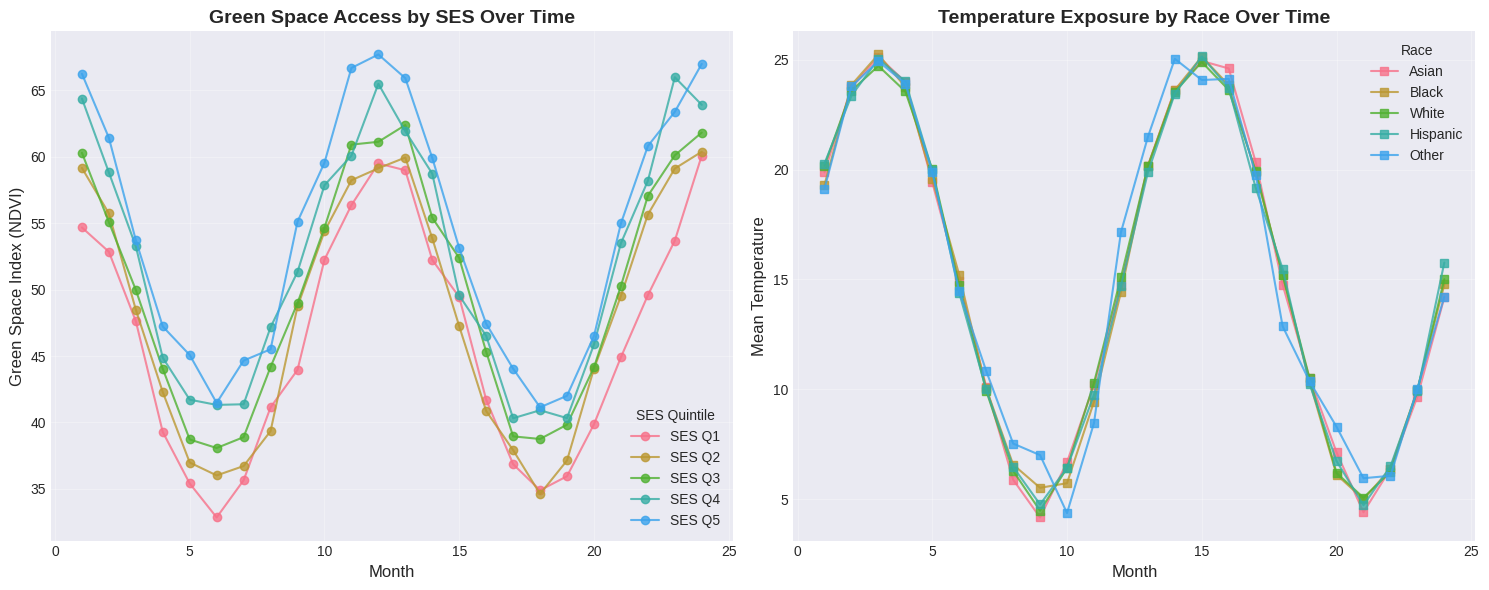


Green space by SES (averaged across all months):
SES_quintile
1    46.237251
2    48.142506
3    50.053209
4    52.218909
5    54.185447
Name: green_ndvi, dtype: float64

Does higher SES correlate with more green space?


In [4]:
#Green space by SES quintile over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Green space by SES over time
for ses in sorted(df['SES_quintile'].unique()):
    ses_data = df[df['SES_quintile'] == ses].groupby('month')['green_ndvi'].mean()
    ax1.plot(ses_data.index, ses_data.values,
             marker='o', label=f'SES Q{ses}', alpha=0.8)

ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Green Space Index (NDVI)', fontsize=12)
ax1.set_title('Green Space Access by SES Over Time', fontsize=14, fontweight='bold')
ax1.legend(title='SES Quintile')
ax1.grid(True, alpha=0.3)

# Temperature by Race over time
for race in df['Race'].unique():
    race_data = df[df['Race'] == race].groupby('month')['temp_mean'].mean()
    ax2.plot(race_data.index, race_data.values,
             marker='s', label=race, alpha=0.8)

ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Mean Temperature', fontsize=12)
ax2.set_title('Temperature Exposure by Race Over Time', fontsize=14, fontweight='bold')
ax2.legend(title='Race')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print("\nGreen space by SES (averaged across all months):")
print(df.groupby('SES_quintile')['green_ndvi'].mean().sort_index())
print("\nDoes higher SES correlate with more green space?")

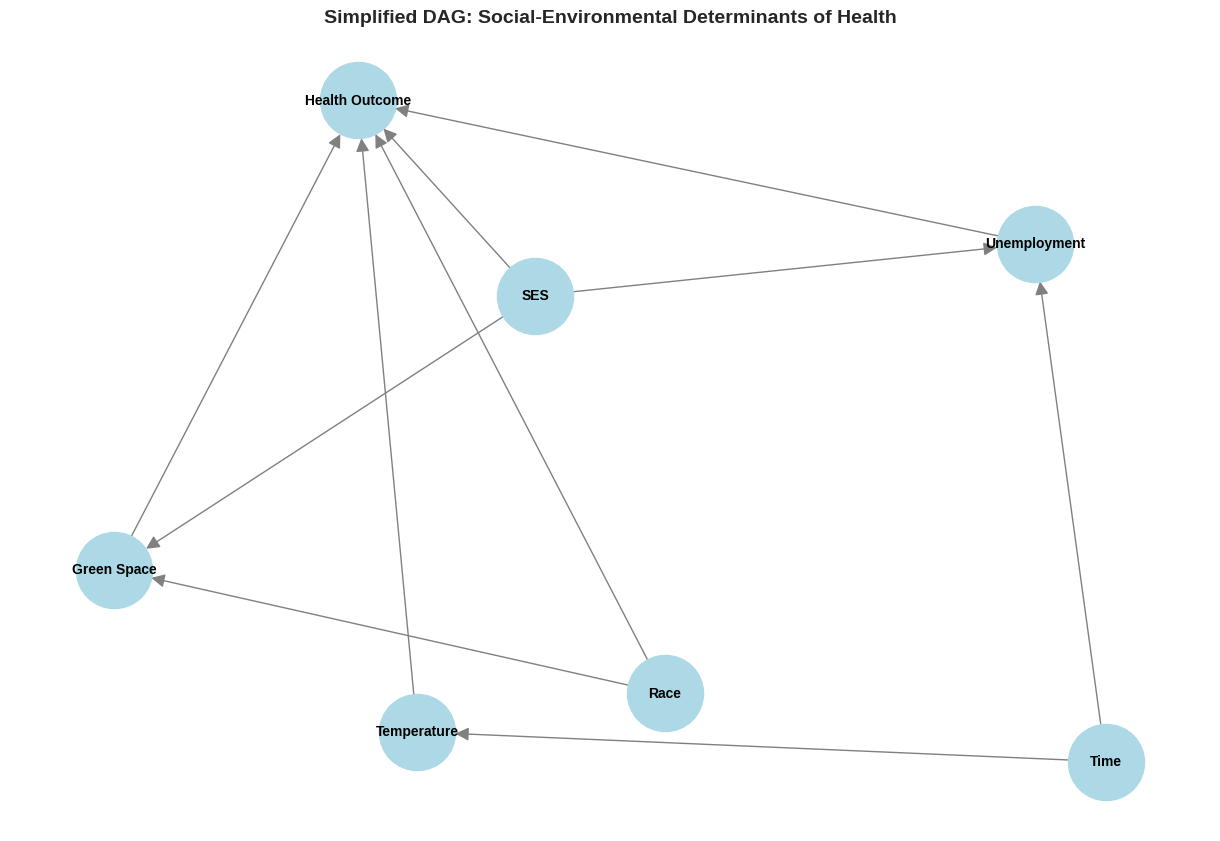

In [5]:
# DAG
import networkx as nx

G = nx.DiGraph()

nodes = ['SES', 'Race', 'Temperature', 'Green Space',
         'Unemployment', 'Health Outcome', 'Time']

G.add_nodes_from(nodes)

# Add edges (causal relationships)
edges = [
    ('SES', 'Green Space'),        # SES affects neighborhood green space
    ('SES', 'Health Outcome'),     # Direct SES effect on health
    ('Race', 'Green Space'),        # Structural racism affects green space
    ('Race', 'Health Outcome'),    # Direct racial disparities
    ('Green Space', 'Health Outcome'),  # Green space affects health
    ('Temperature', 'Health Outcome'),  # Heat affects health
    ('Unemployment', 'Health Outcome'), # Economic stress affects health
    ('Time', 'Temperature'),        # Seasonal changes
    ('Time', 'Unemployment'),      # Economic cycles
    ('SES', 'Unemployment'),       # SES affects job vulnerability
]

G.add_edges_from(edges)

# Plot
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue',
        node_size=3000, font_size=10, font_weight='bold',
        arrows=True, arrowsize=20, edge_color='gray')
plt.title("Simplified DAG: Social-Environmental Determinants of Health",
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [6]:
# Note: Splitting by person ID, not by rows to prevent data leakage

unique_ids = df['id'].unique()
print(f"Total unique individuals: {len(unique_ids)}")

# 70/30 split at the person level
train_ids, test_ids = train_test_split(unique_ids, test_size=0.3, random_state=42)

print(f"Training individuals: {len(train_ids)}")
print(f"Testing individuals: {len(test_ids)}")

train_df = df[df['id'].isin(train_ids)].copy()
test_df = df[df['id'].isin(test_ids)].copy()

print(f"Training observations: {len(train_df)}")
print(f"Testing observations: {len(test_df)}")

Total unique individuals: 200
Training individuals: 140
Testing individuals: 60
Training observations: 3360
Testing observations: 1440


In [7]:
# Static model: Uses only baseline characteristics, ignoring time-varying factors

# For static model, we need one row per person
# Option 1: Use first observation per person
train_static = train_df.groupby('id').first().reset_index()
test_static = test_df.groupby('id').first().reset_index()

# Option 2: Or aggregate outcomes (did person ever have outcome?)
train_static_agg = train_df.groupby('id').agg({
    'SES_quintile': 'first',
    'Race': 'first',
    'outcome': 'max'  # 1 if ever had outcome
}).reset_index()

from sklearn.preprocessing import LabelEncoder

# Encoding categorical variables
le_ses = LabelEncoder()
le_race = LabelEncoder()

X_train_static = pd.DataFrame({
    'SES_quintile': le_ses.fit_transform(train_static['SES_quintile']),
    'Race_encoded': le_race.fit_transform(train_static['Race'])
})

X_test_static = pd.DataFrame({
    'SES_quintile': le_ses.transform(test_static['SES_quintile']),
    'Race_encoded': le_race.transform(test_static['Race'])
})

y_train_static = train_static['outcome']
y_test_static = test_static['outcome']

# Fitting static logistic regression
model_static = LogisticRegression(random_state=42, max_iter=1000)
model_static.fit(X_train_static, y_train_static)

print("Static Model Coefficients:")
for feat, coef in zip(X_train_static.columns, model_static.coef_[0]):
    print(f"  {feat}: {coef:.3f}")

Static Model Coefficients:
  SES_quintile: -0.331
  Race_encoded: 0.220


In [8]:
# Time-aware model: Includes time-varying covariates

# Preparing features including time-varying variables
from sklearn.preprocessing import StandardScaler

# Features for time-varying variables:
feature_cols = ['SES_quintile', 'temp_mean', 'green_ndvi', 'unemploy_rate', 'month']

# Encoding categorical and scale continuous
X_train_time = train_df[feature_cols].copy()
X_test_time = test_df[feature_cols].copy()

# Convert SES to numeric since its ordinal
X_train_time['SES_quintile'] = X_train_time['SES_quintile'].astype(int)
X_test_time['SES_quintile'] = X_test_time['SES_quintile'].astype(int)

# One-hot encode race and add to features
race_train = pd.get_dummies(train_df['Race'], prefix='Race')
race_test = pd.get_dummies(test_df['Race'], prefix='Race')

X_train_time = pd.concat([X_train_time, race_train], axis=1)
X_test_time = pd.concat([X_test_time, race_test], axis=1)

# Scale continuous variables
scaler = StandardScaler()
continuous_cols = ['temp_mean', 'green_ndvi', 'unemploy_rate']
X_train_time[continuous_cols] = scaler.fit_transform(X_train_time[continuous_cols])
X_test_time[continuous_cols] = scaler.transform(X_test_time[continuous_cols])

y_train_time = train_df['outcome']
y_test_time = test_df['outcome']

# Fitting time-aware logistic regression
model_time = LogisticRegression(random_state=42, max_iter=1000)
model_time.fit(X_train_time, y_train_time)

print("\nTime-Aware Model Top Coefficients:")
coef_df = pd.DataFrame({
    'feature': X_train_time.columns,
    'coefficient': model_time.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)
print(coef_df.head(10))


Time-Aware Model Top Coefficients:
         feature  coefficient
0   SES_quintile    -0.169730
5     Race_Asian     0.121187
8     Race_Other    -0.089315
1      temp_mean    -0.078525
7  Race_Hispanic    -0.076086
2     green_ndvi    -0.041874
3  unemploy_rate     0.034223
6     Race_Black     0.029848
9     Race_White    -0.011614
4          month    -0.000843


In [9]:
# Predictions for both models
# Note: For static model, we need to handle the dimension mismatch

# Static model predictions
pred_static = model_static.predict_proba(X_test_static)[:, 1]

# Time-aware model predictions (one per person-month)
pred_time = model_time.predict_proba(X_test_time)[:, 1]

# For fair comparison, aggregate time-aware predictions to person level
test_df['pred_time'] = pred_time
pred_time_person = test_df.groupby('id')['pred_time'].max().values

from sklearn.metrics import roc_auc_score, accuracy_score

# For static model
auc_static = roc_auc_score(y_test_static, pred_static)
acc_static = accuracy_score(y_test_static, (pred_static >= 0.5).astype(int))

# For time-aware model (at person-month level)
auc_time = roc_auc_score(y_test_time, pred_time)
acc_time = accuracy_score(y_test_time, (pred_time >= 0.5).astype(int))

# Comparison table
results = pd.DataFrame({
    'Model': ['Static (Baseline)', 'Time-Aware'],
    'AUC': [auc_static, auc_time],
    'Accuracy': [acc_static, acc_time],
    'Features': ['SES + Race only', 'SES + Race + Time-varying']
})

print("\n" + "="*50)
print("MODEL COMPARISON RESULTS")
print("="*50)
print(results.to_string(index=False))
print("\nImprovement in AUC: {:.3f}".format(auc_time - auc_static))
print("Improvement in Accuracy: {:.3f}".format(acc_time - acc_static))


MODEL COMPARISON RESULTS
            Model      AUC  Accuracy                  Features
Static (Baseline) 0.382963    0.7500           SES + Race only
       Time-Aware 0.544397    0.8625 SES + Race + Time-varying

Improvement in AUC: 0.161
Improvement in Accuracy: 0.113


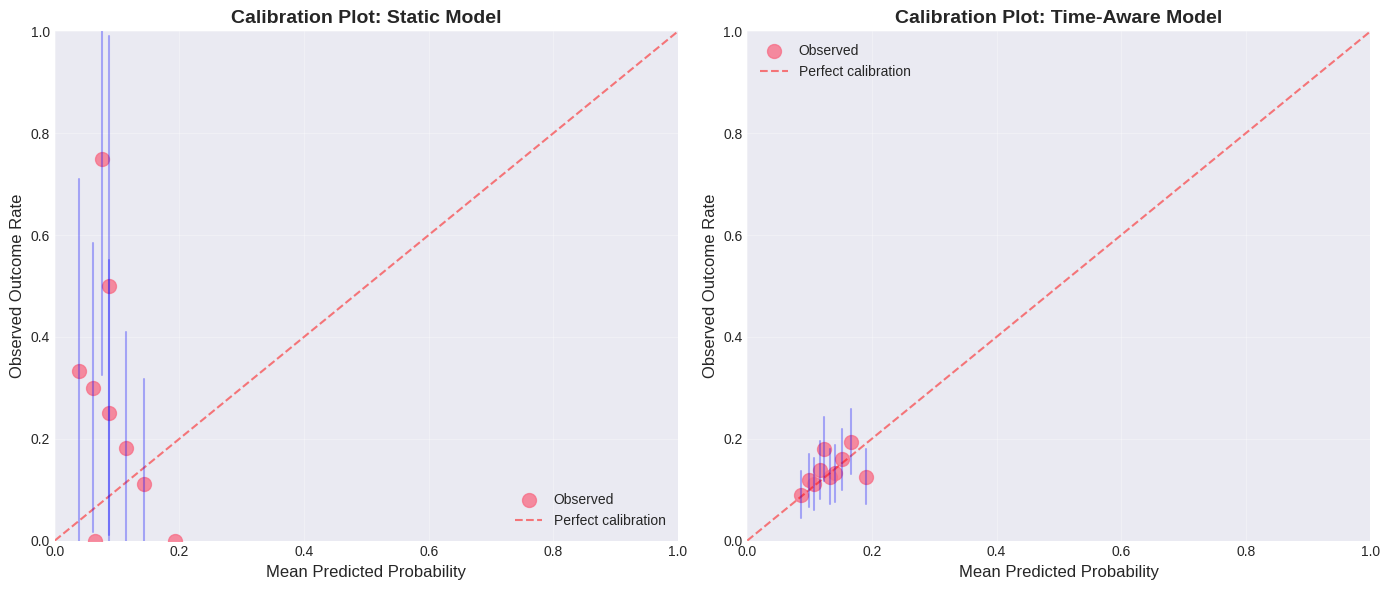


Calibration interpretation:
Points above the diagonal: Model underestimates risk
Points below the diagonal: Model overestimates risk


In [10]:
# Calibration: Whether predicted 30% risk means 30% actually have an outcome

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (preds, y_true, title) in enumerate([
    (pred_static, y_test_static, 'Static Model'),
    (pred_time, y_test_time, 'Time-Aware Model')
]):
    # Create deciles
    pred_df = pd.DataFrame({
        'prediction': preds,
        'outcome': y_true
    })
    pred_df['decile'] = pd.qcut(pred_df['prediction'], q=10, labels=False, duplicates='drop')

    # Calculate calibration
    calibration = pred_df.groupby('decile').agg({
        'prediction': 'mean',
        'outcome': 'mean'
    }).reset_index()

    ax = axes[idx]
    ax.scatter(calibration['prediction'], calibration['outcome'],
              s=100, alpha=0.8, label='Observed')
    ax.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect calibration')

    # Confidence intervals
    for _, row in calibration.iterrows():
        n = len(pred_df[pred_df['decile'] == row['decile']])
        se = np.sqrt(row['outcome'] * (1 - row['outcome']) / n)
        ax.plot([row['prediction'], row['prediction']],
                [row['outcome'] - 1.96*se, row['outcome'] + 1.96*se],
                'b-', alpha=0.3)

    ax.set_xlabel('Mean Predicted Probability', fontsize=12)
    ax.set_ylabel('Observed Outcome Rate', fontsize=12)
    ax.set_title(f'Calibration Plot: {title}', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\nCalibration interpretation:")
print("Points above the diagonal: Model underestimates risk")
print("Points below the diagonal: Model overestimates risk")


SUBGROUP PERFORMANCE: Time-Aware Model

By SES Quintile:
 SES_quintile   N  Outcome_Rate      AUC  Accuracy
            1 168      0.148810 0.350490  0.851190
            2 312      0.169872 0.555183  0.830128
            3 384      0.138021 0.473294  0.861979
            4 336      0.130952 0.530199  0.869048
            5 240      0.095833 0.520938  0.904167

By Race:
    Race   N  Outcome_Rate      AUC  Accuracy
   Asian 120      0.141667 0.545974  0.858333
   Black 360      0.136111 0.526084  0.863889
Hispanic 168      0.154762 0.531148  0.845238
   Other  48      0.166667 0.509375  0.833333
   White 744      0.131720 0.567843  0.868280


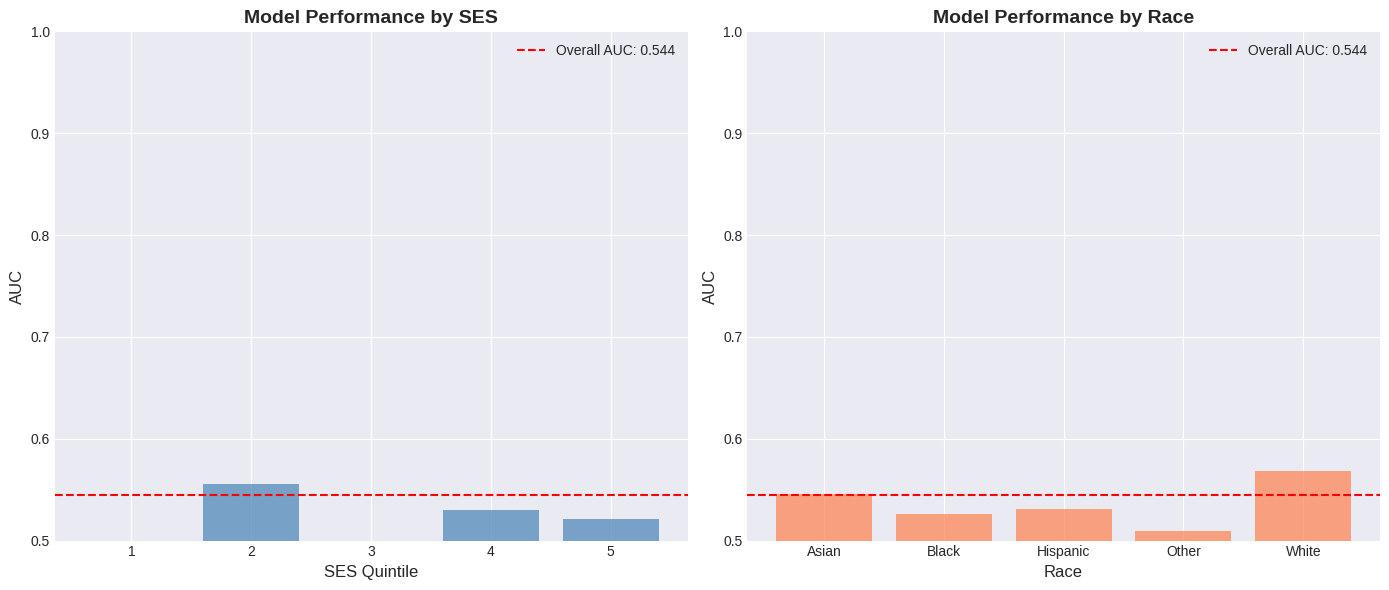


Fairness Analysis:
AUC range across SES: 0.205
AUC range across Race: 0.058


In [11]:
# Evaluate fairness

def calculate_subgroup_metrics(df, predictions, group_col):
    """Calculate metrics by subgroup"""
    results = []

    for group in sorted(df[group_col].unique()):
        mask = df[group_col] == group
        y_true = df.loc[mask, 'outcome']
        y_pred = predictions[mask]

        if len(np.unique(y_true)) > 1:
            auc = roc_auc_score(y_true, y_pred)
            acc = accuracy_score(y_true, (y_pred >= 0.5).astype(int))
        else:
            auc = np.nan
            acc = accuracy_score(y_true, (y_pred >= 0.5).astype(int))

        results.append({
            group_col: group,
            'N': mask.sum(),
            'Outcome_Rate': y_true.mean(),
            'AUC': auc,
            'Accuracy': acc
        })

    return pd.DataFrame(results)

# Calculate subgroup metrics for time-aware model
ses_metrics = calculate_subgroup_metrics(test_df, pred_time, 'SES_quintile')
race_metrics = calculate_subgroup_metrics(test_df, pred_time, 'Race')

print("\n" + "="*50)
print("SUBGROUP PERFORMANCE: Time-Aware Model")
print("="*50)
print("\nBy SES Quintile:")
print(ses_metrics.to_string(index=False))
print("\nBy Race:")
print(race_metrics.to_string(index=False))

# Visalising Disparities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# SES
ax1.bar(ses_metrics['SES_quintile'].astype(str), ses_metrics['AUC'],
        color='steelblue', alpha=0.7)
ax1.axhline(y=auc_time, color='red', linestyle='--', label=f'Overall AUC: {auc_time:.3f}')
ax1.set_xlabel('SES Quintile', fontsize=12)
ax1.set_ylabel('AUC', fontsize=12)
ax1.set_title('Model Performance by SES', fontsize=14, fontweight='bold')
ax1.legend()
ax1.set_ylim([0.5, 1.0])

# Race
ax2.bar(race_metrics['Race'].astype(str), race_metrics['AUC'],
        color='coral', alpha=0.7)
ax2.axhline(y=auc_time, color='red', linestyle='--', label=f'Overall AUC: {auc_time:.3f}')
ax2.set_xlabel('Race', fontsize=12)
ax2.set_ylabel('AUC', fontsize=12)
ax2.set_title('Model Performance by Race', fontsize=14, fontweight='bold')
ax2.legend()
ax2.set_ylim([0.5, 1.0])

plt.tight_layout()
plt.show()

# Fairness Metrics
print("\nFairness Analysis:")
print(f"AUC range across SES: {ses_metrics['AUC'].max() - ses_metrics['AUC'].min():.3f}")
print(f"AUC range across Race: {race_metrics['AUC'].max() - race_metrics['AUC'].min():.3f}")

In [12]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train_time.columns,
    'Coefficient': model_time.coef_[0],
    'Abs_Coefficient': np.abs(model_time.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)
print("\nTop 5 Most Predictive Features:")
print(feature_importance.head())

# Classify features
print("\n" + "="*50)
print("PREDICTIVE vs INTERVENABLE ANALYSIS")
print("="*50)

features_classification = {
    'Highly Predictive + Intervenable': ['green_ndvi', 'unemploy_rate'],
    'Highly Predictive + Not Directly Intervenable': ['Race', 'temp_mean'],
    'Moderately Predictive + Intervenable': ['SES improvements'],
    'Temporal Patterns': ['month']
}

for category, features in features_classification.items():
    print(f"\n{category}:")
    for feat in features:
        print(f"  - {feat}")

print("\n" + "="*50)


FEATURE IMPORTANCE ANALYSIS

Top 5 Most Predictive Features:
         Feature  Coefficient  Abs_Coefficient
0   SES_quintile    -0.169730         0.169730
5     Race_Asian     0.121187         0.121187
8     Race_Other    -0.089315         0.089315
1      temp_mean    -0.078525         0.078525
7  Race_Hispanic    -0.076086         0.076086

PREDICTIVE vs INTERVENABLE ANALYSIS

Highly Predictive + Intervenable:
  - green_ndvi
  - unemploy_rate

Highly Predictive + Not Directly Intervenable:
  - Race
  - temp_mean

Moderately Predictive + Intervenable:
  - SES improvements

Temporal Patterns:
  - month

CAUSAL INTERPRETATION GUIDE


In [14]:
# Reloading data again due to some issues with working with two datasets
from google.colab import files
import io
#Import using timevary.csv first then notes.df

# Reload the timevary dataset as main_df
print("Reloading original dataset...")
uploaded_main = files.upload()
filename_main = next(iter(uploaded_main))
main_df = pd.read_csv(io.BytesIO(uploaded_main[filename_main]), encoding='latin1')

# Load the notes dataset as notes_df (assuming it's already uploaded or upload again)
print("\nLoading notes dataset...")
uploaded_notes = files.upload()
filename_notes = next(iter(uploaded_notes))
notes_df = pd.read_csv(io.BytesIO(uploaded_notes[filename_notes]), encoding='latin1')
print(notes_df.head())

from sklearn.feature_extraction.text import TfidfVectorizer

# Creating TF-IDF features
vectorizer = TfidfVectorizer(max_features=10, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(notes_df['text'])

notes_df['text_score'] = tfidf_matrix.mean(axis=1).A1

# Merge with main data (using main_df)
df_with_text = main_df.merge(
    notes_df[['id', 'month', 'text_score']],
    on=['id', 'month'],
    how='left'
)

print("\nCorrelation of text score with outcome:")
print(df_with_text[['text_score', 'outcome']].corr())

Reloading original dataset...


Saving timevary_assignment.csv to timevary_assignment (1).csv

Loading notes dataset...


Saving notes.csv to notes (1).csv
   id  month                                               text
0   1      1  winter mild park-access SES4 asian food-access...
1   1      2  winter mild greenspace job-loss SES4 asian noi...
2   1      3  seasonal mild greenspace SES4 asian support cl...
3   1      4  seasonal mild low-greenspace job-loss SES4 asi...
4   1      5  seasonal mild greenspace SES4 asian support co...

Correlation of text score with outcome:
            text_score   outcome
text_score    1.000000  0.013517
outcome       0.013517  1.000000
